In [1]:
#import 
import pandas as pd
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')
from warnings import filterwarnings;
from sklearn.preprocessing import MinMaxScaler
filterwarnings('ignore');

In [2]:
train_df=pd.read_csv('optiver-trading-at-the-close/train.csv')

In [4]:
train_df.head(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,1962.72,1.000635,5647.65,1.0,6.779432,0,0_0_5
6,6,0,0,969969.40,1,1.000115,3647503.98,NaN,NaN,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819,0,0_0_6
7,7,0,0,9412959.10,1,0.999818,21261245.87,NaN,NaN,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801,0,0_0_7
8,8,0,0,2394875.85,1,0.999916,9473209.08,NaN,NaN,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001,0,0_0_8
9,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,6191.00,1.000646,6199.00,1.0,7.970333,0,0_0_9


In [8]:
train_df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [9]:
print("number of unique stocks: " , len(train_df['stock_id'].unique()))
print("number of unique date: " , len(train_df['date_id'].unique()))
print("number of unique seconds in bucket: " , len(train_df['seconds_in_bucket'].unique()))

number of unique stocks:  200
number of unique date:  481
number of unique seconds in bucket:  55


In [10]:
def inspect_columns(df):
    
    # Get this function from other's Jupyter
    # A helper function that does a better job than df.info() and df.describe()
    
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

inspect_columns(train_df)

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0.00,0,45,199,int64
date_id,False,481,False,0.00,0,62,480,int64
seconds_in_bucket,False,55,False,0.00,0,480,540,int64
imbalance_size,False,2971863,True,0.00,3180602.69,0.0,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0.00,1,0,-1,int64
reference_price,False,28741,True,0.00,0.999812,1.001425,1.002129,float64
matched_size,False,2948862,True,0.00,13380276.64,899768741.22,24073677.32,float64
far_price,False,95739,True,55.26,NaN,1.001425,1.000859,float64
near_price,False,84625,True,54.55,NaN,1.001425,1.001494,float64
bid_price,False,28313,True,0.00,0.999812,1.001394,1.002129,float64


Note: 200x481x55 does not equal to 5237980 since some values are missing.

## Observation Checkpoint: 
- The training data consist of 200 * 481 = 96200 time series

- Each time series are 55 steps long, and each time series represents the last 10 mins of a given stock on a given trading date.

- 5291000 - 5,237,980 = 53020 data missing.

- time_id is just a new id for the permutation of seconds_in_bucket and date_id.

- row_id is a string concatenation of date_id, seconds_in_bucket, and stock_id, separated with underscores.

- "target" is the target variable we want to predict.

In [17]:
# Check if all the time series are 55 steps long

(train_df
    .groupby(['stock_id', 'date_id'])
    ['seconds_in_bucket'] # Extract the column of interest
    .count() # Count the number of rows in each permutation of stock_id and date_id
    .apply(lambda x: x == 55) # Check if every count is 55
    .all() # Check if all the booleans are True
)

True

In [19]:
all_stock_id = np.sort(train_df["stock_id"].unique())
all_date_id = np.sort(train_df["date_id"].unique())
multi_index = pd.MultiIndex.from_product(
    iterables=[all_date_id, all_stock_id], 
    names=["date_id", "stock_id"]
)
missing_data = (train_df
    .loc[:, ["date_id", "stock_id"]]
    .assign(in_train=True) # Add a new column to indicate if the row is in the training data
    .set_index(["date_id", "stock_id"])
    .merge(multi_index.to_frame(), how="right", left_index=True, right_index=True)
    .query("in_train.isna()") # Filter out the missing data
    .set_index("stock_id", drop=True)
    ["date_id"]
)
missing_data.groupby("stock_id").count().sort_values()

stock_id
73       1
99       1
78       4
69      37
156     37
150     59
153     70
199     88
79     181
135    191
102    295
Name: date_id, dtype: int64

## Observation Checkpoint:
- Some stocks miss data on some days entirely rather than a few irregular lose steps.
- We identify the stock id with the numbers of days of data missing.

In [20]:
# Analyze auction book and order book

def time_series_plot(df, cols, stock_id, date_id):
    # A helper function to plot the time seires for a given stock in a given date
    (df
        .query(f'stock_id == {stock_id} & date_id == {date_id}')
        .loc[:, ['seconds_in_bucket'] + cols]
        # .replace(0, np.nan)
        .set_index('seconds_in_bucket')
        .plot(title=f'Stock {stock_id} on Day {date_id}', figsize=(10, 4), linewidth=1)
    )

In [26]:
stock_id = 1
date_id = 1

(train_df
    .query(f'stock_id == {stock_id} & date_id == {date_id}')
    .drop(columns=['stock_id', 'date_id', 'time_id', 'row_id'])
    .head(10)
)

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
10506,0,648832.14,-1,0.999710,2714505.33,NaN,NaN,0.999884,517.35,1.000232,1035.06,1.000000,7.330179
10697,10,576049.80,-1,0.999884,2787287.67,NaN,NaN,0.999826,17244.00,1.000812,17261.00,1.000319,-1.360178
10888,20,527413.26,-1,0.998782,2816090.16,NaN,NaN,0.998782,9129.78,0.999594,35859.20,0.998947,11.500120
11079,30,527413.26,-1,0.998840,2816090.16,NaN,NaN,0.998782,26355.78,0.999536,45338.57,0.999060,14.779568
11270,40,522756.57,-1,0.999420,2820746.85,NaN,NaN,0.999246,1723.40,1.000696,51777.00,0.999293,5.420446
11461,50,522756.57,-1,0.999188,2820746.85,NaN,NaN,0.999188,10339.80,1.000754,17260.00,0.999775,1.579523
11652,60,522756.57,-1,0.999652,2820746.85,NaN,NaN,0.999652,2413.74,1.000638,345.16,1.000515,-5.959868
11843,70,505164.63,-1,0.999652,2838511.26,NaN,NaN,0.999652,17413.41,1.000464,17255.00,1.000060,0.109673
12034,80,524998.68,-1,0.999710,2838511.26,NaN,NaN,0.999652,17413.41,1.000116,172.49,1.000111,-3.550053
12225,90,510166.26,-1,1.000174,2853343.68,NaN,NaN,1.000000,17247.00,1.000754,4487.60,1.000598,-7.420182


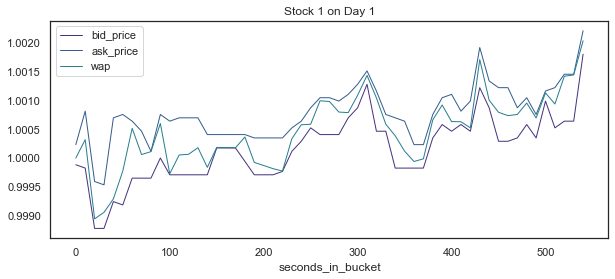

In [22]:
# bid_price vs. ask_price vs. wap
time_series_plot(
    df=train_df, 
    cols=['bid_price','ask_price', 'wap'], 
    stock_id = 1,
    date_id = 1
)

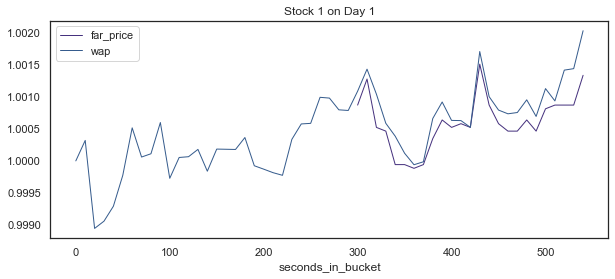

In [28]:
# far_price vs. wap
time_series_plot(
    df=train_df, 
    cols=['far_price', 'wap'],
    stock_id =1, 
    date_id = 1,
)

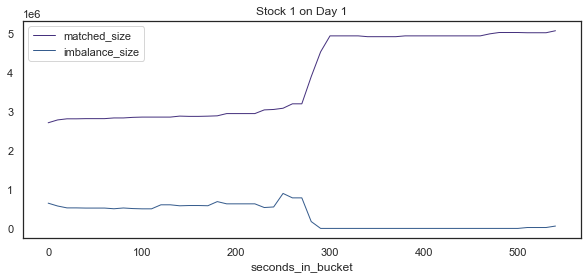

In [30]:
# matched_size vs. imbalance_size
time_series_plot(
    df=train_df, 
    cols=['matched_size', 'imbalance_size'], 
    stock_id = 1, 
    date_id = 1,
)

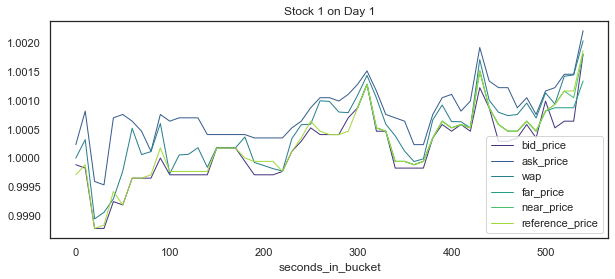

In [34]:
# analyze combined book 
time_series_plot(
    df=train_df, 
    cols=['bid_price', 'ask_price', 'wap', 'far_price', 'near_price', 'reference_price'], 
    stock_id = 1, 
    date_id = 1,
)

## Obersvation Checkpoint:
- wap is always larger than bid_price and smaller ask_price.
- If bid_size is larger than ask_size, then wap would be closer to ask_price, and vice versa.
- If the bid_size increase, the buyers are more aggressive, so the fair price should be closer to the ask_price.
- Far Price shows data only after second_in_bucket=300, which corresponds to 3:55 p.m
- matched_size and imbalance_size significantly diverge at size after second_in_bucket=240 (3:54 p.m.)
- imbalance_size tends to decrease, and matched_size tends to increase

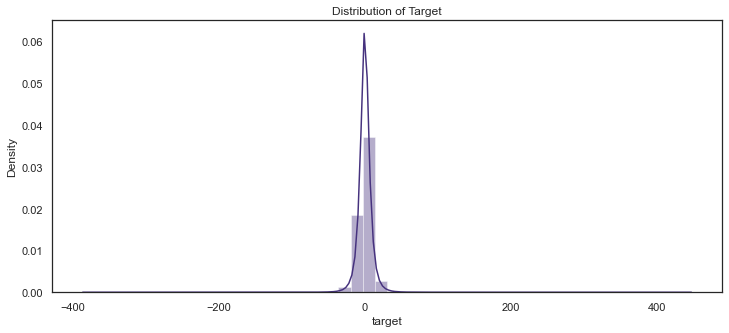

In [39]:
# target 
"""
def: target is the 60 second future move in the wap of the stock,
less the 60 second future move of the synthetic index.
"""

plt.figure(figsize=(12,5))
plt.title("Distribution of Target")
ax = sns.distplot(train_df['target'])

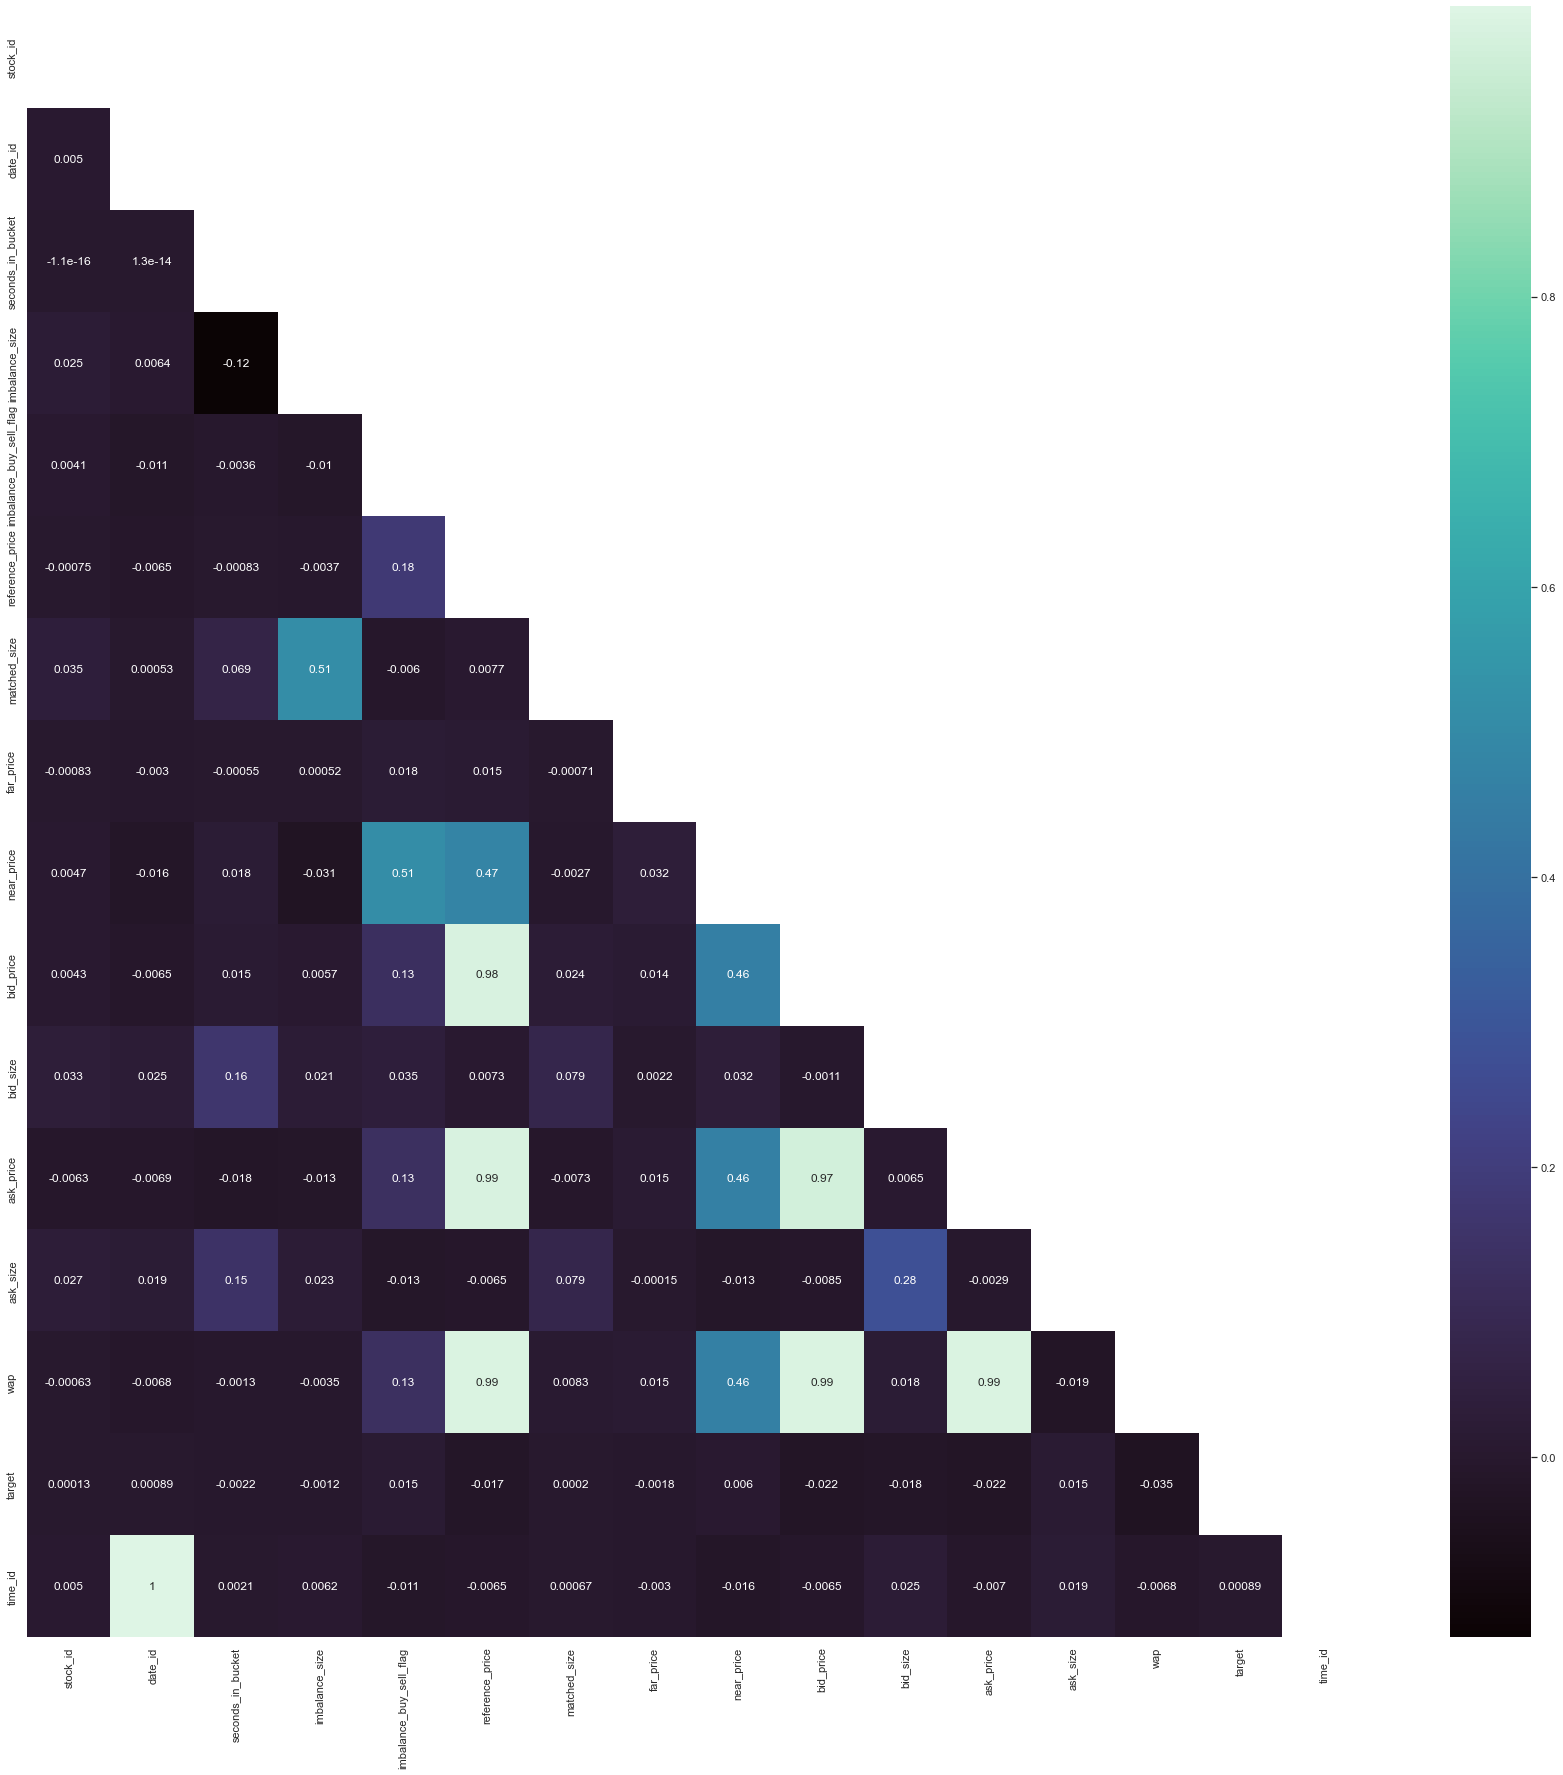

In [40]:
# corr map 

plt.figure(figsize=(30,30))
corr=train_df.corr()
sns.heatmap(corr,annot=True,cmap='mako',mask=np.triu(corr))
plt.show()

## Data Preprocessing

In [42]:
#handle null values

numerical_columns = ['imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'ask_price', 'wap', 'target']

train_df['target'].fillna(method='ffill', inplace=True)

for column in numerical_columns:
    mean_value = train_df[column].mean()
    train_df[column].fillna(mean_value, inplace=True)

In [52]:
# data encoding for stock_id and imbalanc_buy_sell

encoded_df = train_df.copy()
encoded_df = pd.get_dummies(encoded_df, columns=['stock_id', 'imbalance_buy_sell_flag'], prefix=['stock', 'imbalance_flag'], drop_first=False)
print(encoded_df.columns)
columns_to_drop = ['stock_id', 'imbalance_buy_sell_flag']
encoded_df.drop(columns=columns_to_drop, errors='ignore', inplace=True)
encoded_df

Index(['date_id', 'seconds_in_bucket', 'imbalance_size', 'reference_price',
       'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size',
       'ask_price',
       ...
       'stock_193', 'stock_194', 'stock_195', 'stock_196', 'stock_197',
       'stock_198', 'stock_199', 'imbalance_flag_-1', 'imbalance_flag_0',
       'imbalance_flag_1'],
      dtype='object', length=218)


,date_id,seconds_in_bucket,imbalance_size,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,stock_9,stock_10,stock_11,stock_12,stock_13,stock_14,stock_15,stock_16,stock_17,stock_18,stock_19,stock_20,stock_21,stock_22,stock_23,stock_24,...,stock_163,stock_164,stock_165,stock_166,stock_167,stock_168,stock_169,stock_170,stock_171,stock_172,stock_173,stock_174,stock_175,stock_176,stock_177,stock_178,stock_179,stock_180,stock_181,stock_182,stock_183,stock_184,stock_185,stock_186,stock_187,stock_188,stock_189,stock_190,stock_191,stock_192,stock_193,stock_194,stock_195,stock_196,stock_197,stock_198,stock_199,imbalance_flag_-1,imbalance_flag_0,imbalance_flag_1
0,0,0,3180602.69,0.999812,13380276.64,1.001713,0.999660,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,166603.91,0.999896,1642214.25,1.001713,0.999660,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,302879.87,0.999561,1819368.03,1.001713,0.999660,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,11917682.27,1.000171,18389745.62,1.001713,0.999660,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,447549.96,0.999532,17860614.95,1.001713,0.999660,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,480,540,2440722.89,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
5237976,480,540,349510.47,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
5237977,480,540,0.00,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
5237978,480,540,1000898.84,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


## Potential useful index: 
- Price Spread: The difference between the ask price and bid price, capturing the spread between buying and selling prices.
- Volume-Weighted Average Price (VWAP): Computed separately for each stock, representing the average price at which a stock has traded throughout the day, weighted by volume.
- Rolling Mean of Matched Size: The 10-period rolling mean of the matched size, measuring trading activity over time for each stock.
- Imbalance Ratio: The ratio of the imbalance size to the matched size, indicating the degree of order imbalance in the auction.
- Cumulative Bid Size: The cumulative sum of bid sizes for each stock, showing the total demand at different time points.
- Skewness of VWAP: A measure of the asymmetry of the VWAP distribution for each stock.
- Kurtosis of VWAP: A measure of the "tailedness" of the VWAP distribution for each stock, assessing extreme values.

In [60]:
#feature engineering

threshold = 100000  #High volume threshhold
def get_kurtosis(x):
    return x.kurt()

stock_columns = [col for col in encoded_df.columns if col.startswith('stock_')]
encoded_df['price_spread'] = encoded_df['ask_price'] - encoded_df['bid_price']
encoded_df['vwap'] = encoded_df.groupby(stock_columns)['wap'].transform('mean')
encoded_df['rolling_mean_matched_size'] = encoded_df.groupby(stock_columns)['matched_size'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
encoded_df['imbalance_ratio'] = encoded_df['imbalance_size'] / encoded_df['matched_size']
encoded_df['cumulative_bid_size'] = encoded_df.groupby(stock_columns)['bid_size'].cumsum()
encoded_df['wap_skewness'] = encoded_df.groupby(stock_columns)['wap'].transform('skew')
encoded_df['wap_kurtosis'] = encoded_df.groupby(stock_columns)['wap'].transform(get_kurtosis)
encoded_df['is_high_volume'] = (encoded_df['bid_size'] + encoded_df['ask_size'] > threshold).astype('bool')

encoded_df.head()

,date_id,seconds_in_bucket,imbalance_size,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,stock_9,stock_10,stock_11,stock_12,stock_13,stock_14,stock_15,stock_16,stock_17,stock_18,stock_19,stock_20,stock_21,stock_22,stock_23,stock_24,...,stock_171,stock_172,stock_173,stock_174,stock_175,stock_176,stock_177,stock_178,stock_179,stock_180,stock_181,stock_182,stock_183,stock_184,stock_185,stock_186,stock_187,stock_188,stock_189,stock_190,stock_191,stock_192,stock_193,stock_194,stock_195,stock_196,stock_197,stock_198,stock_199,imbalance_flag_-1,imbalance_flag_0,imbalance_flag_1,price_spread,vwap,rolling_mean_matched_size,imbalance_ratio,cumulative_bid_size,wap_skewness,wap_kurtosis,is_high_volume
0,0,0,3180602.69,0.999812,13380276.64,1.001713,0.99966,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000214,0.999842,13380276.64,0.237708,60651.50,0.130012,2.661938,False
1,0,0,166603.91,0.999896,1642214.25,1.001713,0.99966,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.000764,0.999929,1642214.25,0.101451,3233.04,0.307577,2.733586,False
2,0,0,302879.87,0.999561,1819368.03,1.001713,0.99966,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.000895,1.000145,1819368.03,0.166475,37956.00,-0.562645,11.202168,False
3,0,0,11917682.27,1.000171,18389745.62,1.001713,0.99966,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.000215,0.999977,18389745.62,0.648061,2324.90,0.200139,3.383347,True
4,0,0,447549.96,0.999532,17860614.95,1.001713,0.99966,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.000622,0.999863,17860614.95,0.025058,16485.54,0.086339,1.682726,False


In [62]:
#scaling
columns_to_scale = [
    'imbalance_size',
    'reference_price',
    'matched_size',
    'far_price',
    'near_price',
    'bid_price',
    'bid_size',
    'ask_price',
    'ask_size',
    'wap',
    'price_spread',
    'vwap',
    'rolling_mean_matched_size',
    'imbalance_ratio',
    'cumulative_bid_size',
    'wap_skewness',
    'wap_kurtosis'
]

scaler = MinMaxScaler()
encoded_df[columns_to_scale] = scaler.fit_transform(encoded_df[columns_to_scale])
encoded_df.head()

,date_id,seconds_in_bucket,imbalance_size,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,stock_9,stock_10,stock_11,stock_12,stock_13,stock_14,stock_15,stock_16,stock_17,stock_18,stock_19,stock_20,stock_21,stock_22,stock_23,stock_24,...,stock_171,stock_172,stock_173,stock_174,stock_175,stock_176,stock_177,stock_178,stock_179,stock_180,stock_181,stock_182,stock_183,stock_184,stock_185,stock_186,stock_187,stock_188,stock_189,stock_190,stock_191,stock_192,stock_193,stock_194,stock_195,stock_196,stock_197,stock_198,stock_199,imbalance_flag_-1,imbalance_flag_0,imbalance_flag_1,price_spread,vwap,rolling_mean_matched_size,imbalance_ratio,cumulative_bid_size,wap_skewness,wap_kurtosis,is_high_volume
0,0,0,0.001067,0.453767,0.001734,0.002287,0.406838,0.455184,0.002003,0.436196,0.000156,0.443856,-3.029704,0,0_0_0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.011696,0.313137,0.001737,0.001918,6.477775e-06,0.360640,0.012921,False
1,0,0,0.000056,0.454358,0.000212,0.002287,0.406838,0.455774,0.000107,0.440790,0.000379,0.443856,-5.519986,0,0_0_1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.042184,0.401664,0.000213,0.000819,3.355862e-07,0.377188,0.013488,False
2,0,0,0.000102,0.452002,0.000235,0.002287,0.406838,0.452316,0.001253,0.438167,0.000349,0.443856,-8.389950,0,0_0_2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.049446,0.622319,0.000236,0.001343,4.049983e-06,0.296086,0.080514,False
3,0,0,0.003997,0.456291,0.002383,0.002287,0.406838,0.456496,0.000077,0.437558,0.008805,0.443856,-4.010200,0,0_0_3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.011752,0.450949,0.002388,0.005230,2.384403e-07,0.367175,0.018631,True
4,0,0,0.000150,0.451798,0.002315,0.002287,0.406838,0.452253,0.000544,0.436124,0.000008,0.443856,-7.349849,0,0_0_4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.034313,0.333972,0.002319,0.000202,1.753237e-06,0.356569,0.005171,False


In [63]:
encoded_df.to_csv("preprocessed_train_v1.csv", index=False) 